In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import holidays
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Load main data
file_path = "../data/ChallengeXHEC23022024.xlsx"


excel_data = pd.ExcelFile(file_path)


jan24_df = pd.read_excel(excel_data, sheet_name="JAN24")
clients_df = pd.read_excel(excel_data, sheet_name="clients")
intervenants_df = pd.read_excel(excel_data, sheet_name="intervenants")

In [3]:
# Loading and merging commute data
commute_file_paths = [
    '../data/commute_bicycling_clients.csv',
    '../data/commute_driving_clients.csv',
    '../data/commute_bicycling_care_clients.csv',
    '../data/commute_bicycling_clients_care.csv',
    '../data/commute_driving_care_clients.csv',
    '../data/commute_driving_clients_care.csv'
]


commute_dataframes = [pd.read_csv(file) for file in commute_file_paths]


for df in commute_dataframes:
    if df.columns[0] not in ['pair']: #standardizing column names
        df.rename(columns={df.columns[0]: 'pair'}, inplace=True)

commute_data_df = pd.concat(commute_dataframes, ignore_index=True)

In [4]:
commute_data_df

,pair,commute_seconds,commute_meters,source,destination,commute_method
0,"(559475456, 559475456)",0,0,559475456,559475456,bicycling
1,"(559475456, 559277088)",0,0,559475456,559277088,bicycling
2,"(559475456, 87852633)",2655,12103,559475456,87852633,bicycling
3,"(559475456, 243033408)",1092,4215,559475456,243033408,bicycling
4,"(559475456, 814940942)",426,2015,559475456,814940942,bicycling
...,...,...,...,...,...,...
39171,"(334442311, 776399834)",856,10016,334442311,776399834,driving
39172,"(621952854, 776399834)",386,2775,621952854,776399834,driving
39173,"(1452858131, 776399834)",763,7634,1452858131,776399834,driving
39174,"(846949801, 776399834)",560,3597,846949801,776399834,driving


In [5]:
jan24_df

,ID Client,ID Intervenant,Date,Heure de début,Heure de fin,Prestation
0,559475456,162858075,2024-01-01,07:15:00,07:45:00,REPAS
1,559277088,162858075,2024-01-01,07:45:00,08:30:00,TOILETTE
2,87852633,78007018,2024-01-01,07:45:00,08:30:00,TOILETTE
3,243033408,810259688,2024-01-01,07:45:00,08:15:00,TOILETTE
4,814940942,710283561,2024-01-01,07:45:00,09:20:00,TOILETTE
...,...,...,...,...,...,...
2865,559277088,710283561,2024-01-31,19:00:00,19:15:00,REPAS
2866,714782168,810259688,2024-01-31,19:00:00,20:00:00,REPAS
2867,559475456,710283561,2024-01-31,19:15:00,20:00:00,TOILETTE
2868,803656603,854577575,2024-01-31,19:20:00,19:50:00,TOILETTE


In [6]:
clients_df

,ID Client,Latitude,Longitude
0,559475456,48.721052,1.375689
1,559277088,48.721052,1.375689
2,87852633,48.691944,1.498773
3,243033408,48.726393,1.332848
4,814940942,48.733174,1.370689
...,...,...,...
113,334442311,48.771381,1.292168
114,621952854,48.742805,1.351704
115,1452858131,48.776801,1.370417
116,846949801,48.733484,1.371047


In [7]:
intervenants_df

,ID Intervenant,Latitude,Longitude,Compétences,Permis,Véhicule personnel,Dispo / Indispo
0,838320706,48.738516,1.391971,"AIDE MENAGERE, REPAS, TOILETTE",Oui,Oui,"Indispo 01/01, 30/01, 31/01"
1,609468992,48.640555,1.232581,"TOILETTE, REPAS, VIE SOCIALE, AIDE MENAGERE",Oui,Oui,"Indispo Tous les mercredis + 13/01, 14/01, 27/..."
2,78012267,48.729206,1.371985,"HOMMES TOUTES MAINS, JARDINAGE",Oui,Oui,Dispo le 25/01
3,818696864,48.744702,1.357921,"REPAS, AIDE MENAGERE, ACCOMPAGNEMENTS COURSES,...",Oui,Oui,Indispo tous les samedis et dimanche
4,746414886,48.769455,1.197644,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,Indispo tous les mercredis + le 05/01
5,78005437,48.712418,1.356278,"AIDE MENAGERE, ADMINISTRATION, REPAS, TOILETTE...",Oui,Oui,Indispo tous les samedis et dimanche
6,213237245,48.763226,1.241120,"TOILETTE, REPAS, AIDE MENAGERE",Oui,Oui,"Indispo 01/01, 02/01, 03/01, 13/01, 14/01, 16/..."
7,813991780,48.692715,1.073195,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,"Indispo tous les mercredis, vendredi, samedi, ..."
8,856089133,48.645418,1.523077,"ACCOMPAGNEMENTS COURSES PA, REPAS, TOILETTE, A...",Non,Non,"Indispo 05/01, 09/01, 11/01 + du 18/01 au 31/0..."
9,700168298,48.758099,1.210611,"TOILETTE, REPAS, AIDE MENAGERE, ACCOMPAGNEMENT...",Oui,Oui,"Dispo le 01/01, 30/01 et 31/01"


In [8]:
# Analyze start/end times for each type of service
jan24_df["Heure de début"] = pd.to_datetime(
    jan24_df["Heure de début"], format="%H:%M:%S"
).dt.time
jan24_df["Heure de fin"] = pd.to_datetime(
    jan24_df["Heure de fin"], format="%H:%M:%S"
).dt.time
service_constraints = jan24_df.groupby("Prestation").agg(
    {"Heure de début": ["min", "max"], "Heure de fin": ["min", "max"]}
)
service_constraints.columns = [
    "Start Time Earliest",
    "Start Time Latest",
    "End Time Earliest",
    "End Time Latest",
]
service_constraints.reset_index(inplace=True)


print(service_constraints)

                    Prestation Start Time Earliest Start Time Latest  \
0   ACCOMPAGNEMENTS COURSES PA            08:45:00          17:30:00   
1               ADMINISTRATION            07:30:00          14:30:00   
2                AIDE MENAGERE            08:00:00          18:15:00   
3                 COORDINATION            08:30:00          17:40:00   
4              FEMME DE MENAGE            09:00:00          09:00:00   
5                    FORMATION            08:30:00          19:30:00   
6              GARDE D'ENFANTS            12:00:00          18:20:00   
7          HOMMES TOUTES MAINS            10:00:00          13:00:00   
8                        REPAS            07:00:00          19:45:00   
9                     TOILETTE            07:00:00          20:55:00   
10                 VIE SOCIALE            09:00:00          17:40:00   
11             VISITE MEDICALE            10:20:00          10:20:00   

   End Time Earliest End Time Latest  
0           10:00:00    

In [9]:
prestation_segmented_data = {prestation: group for prestation, group in jan24_df.groupby('Prestation')}


toilette_data = prestation_segmented_data['TOILETTE']  # Replace 'TOILETTE' with the desired service segmented data


In [10]:
# Segment clients according to their needs
client_needs = (
    jan24_df.groupby(["ID Client", "Prestation"]).size().unstack(fill_value=0)
)

print(client_needs)

Prestation  ACCOMPAGNEMENTS COURSES PA  ADMINISTRATION  AIDE MENAGERE  \
ID Client                                                               
78690893                             0               0             28   
78691334                             4               0             13   
78691389                             0               0              5   
78691461                             0               0              4   
78692265                             2               0              5   
...                                ...             ...            ...   
1452740690                           1               0              0   
1452763176                           0               0              3   
1452775101                           0               0              0   
1452858131                           0               0              0   
1453084257                           0               0              2   

Prestation  COORDINATION  FEMME DE MENAGE  FORMATI

In [11]:
# Segment days according to the services offered
jan24_df["Day of Week"] = jan24_df["Date"].dt.dayofweek
jan24_df["Day Type"] = jan24_df["Day of Week"].apply(
    lambda x: "Weekend" if x > 4 else "Weekday"
)
day_segmentation = (
    jan24_df.groupby(["Day Type", "Prestation"]).size().unstack(fill_value=0)
)

day_segmentation.T

Day Type,Weekday,Weekend
Prestation,,
ACCOMPAGNEMENTS COURSES PA,83,0
ADMINISTRATION,79,0
AIDE MENAGERE,435,8
COORDINATION,10,0
FEMME DE MENAGE,4,0
FORMATION,15,0
GARDE D'ENFANTS,10,0
HOMMES TOUTES MAINS,2,0
REPAS,696,214


In [12]:
day_seg_inv = day_segmentation.T
print(
    "Weekday services: ", day_seg_inv[day_seg_inv.Weekday > 0].index.to_list()
)
print(
    "Weekend services: ", day_seg_inv[day_seg_inv.Weekend > 0].index.to_list()
)

Weekday services:  ['ACCOMPAGNEMENTS COURSES PA', 'ADMINISTRATION', 'AIDE MENAGERE', 'COORDINATION', 'FEMME DE MENAGE', 'FORMATION', "GARDE D'ENFANTS", 'HOMMES TOUTES MAINS', 'REPAS', 'TOILETTE', 'VIE SOCIALE', 'VISITE MEDICALE']
Weekend services:  ['AIDE MENAGERE', 'REPAS', 'TOILETTE', 'VIE SOCIALE']


In [13]:
services_per_day = jan24_df.groupby('Date').size()

fig = go.Figure()
fig.add_trace(go.Scatter(x=services_per_day.index, y=services_per_day.values, mode='lines+markers', marker_color='blue'))
fig.update_layout(title='Total Number of Services Provided Per Day', xaxis_title='Date', yaxis_title='Number of Services', xaxis_tickangle=-45)
fig.show()


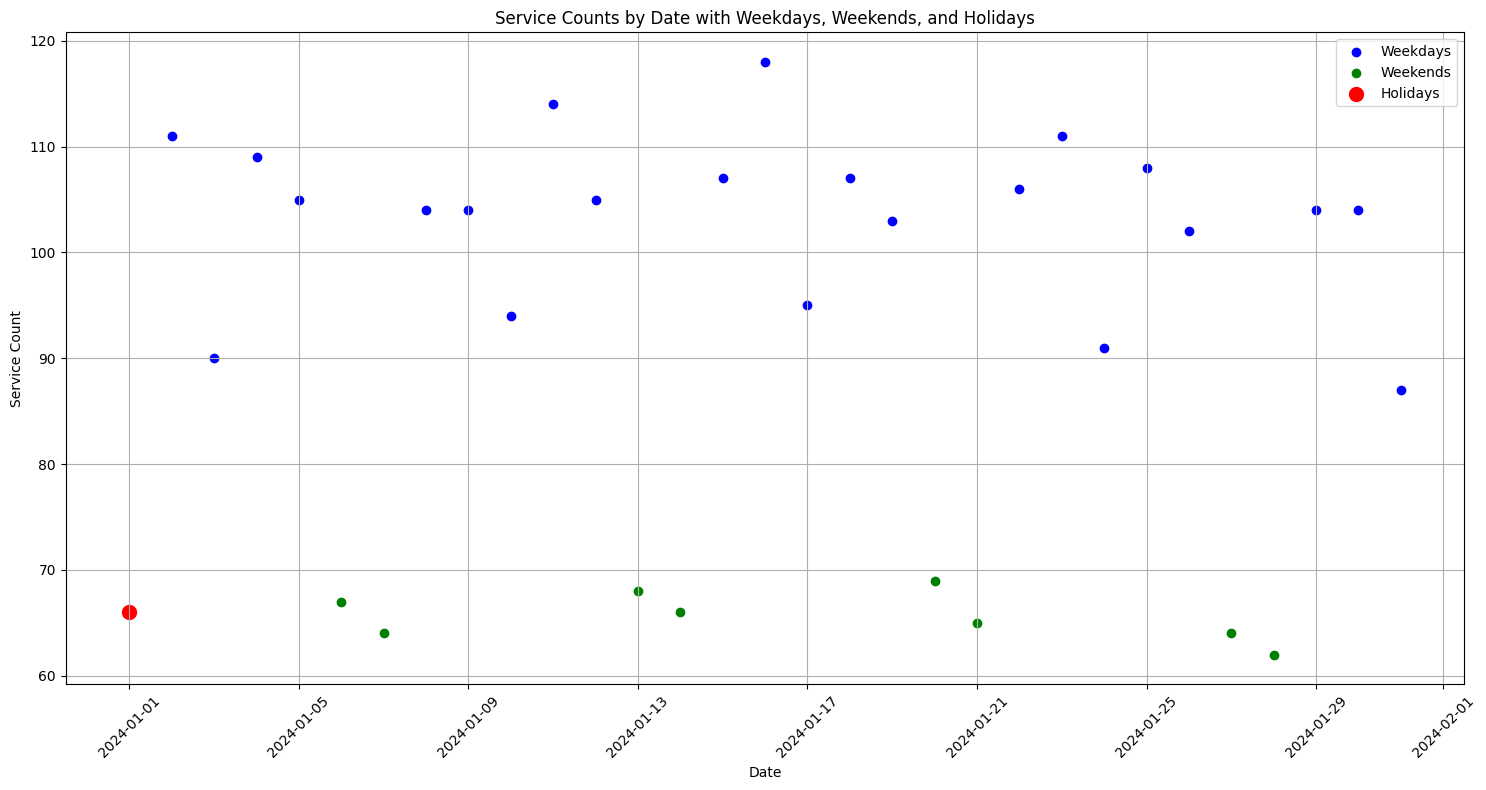

In [14]:
# Extracting weekdays and weekends
jan24_df['Day Type'] = np.where(jan24_df['Date'].dt.dayofweek < 5, 'Weekday', 'Weekend')

fr_holidays = holidays.France(years=2024) # extracting French holidays
jan24_df['Holiday'] = jan24_df['Date'].apply(lambda x: fr_holidays.get(x))

# Counting services per day and categorizing them
daily_services = jan24_df.groupby(['Date', 'Day Type']).size().reset_index(name='Service Count')
daily_services['Holiday'] = daily_services['Date'].apply(lambda x: fr_holidays.get(x) is not None)

# Plotting
plt.figure(figsize=(15, 8))
weekday_services = daily_services[daily_services['Day Type'] == 'Weekday']
plt.scatter(weekday_services['Date'], weekday_services['Service Count'], color='blue', label='Weekdays')
weekend_services = daily_services[daily_services['Day Type'] == 'Weekend']
plt.scatter(weekend_services['Date'], weekend_services['Service Count'], color='green', label='Weekends')
holiday_services = daily_services[daily_services['Holiday']]
plt.scatter(holiday_services['Date'], holiday_services['Service Count'], color='red', label='Holidays', s=100)
plt.title('Service Counts by Date with Weekdays, Weekends, and Holidays')
plt.xlabel('Date')
plt.ylabel('Service Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Frequency of each service type by day of week
jan24_df['Day of Week'] = jan24_df['Date'].dt.day_name()
service_by_day = jan24_df.groupby(['Prestation', 'Day of Week']).size().unstack(fill_value=0)

fig = px.bar(service_by_day, barmode='group', labels={'value': 'Frequency', 'variable': 'Day of Week'}, title='Service Frequency by Day of the Week')
fig.show()

# Analyzing service corelation
service_combinations = jan24_df.pivot_table(index=['Date', 'ID Client'], columns='Prestation', aggfunc='size', fill_value=0)
service_correlation = service_combinations.corr()

fig = px.imshow(service_correlation, x=service_correlation.index, y=service_correlation.columns)
fig.update_layout(title='Service Correlation Heatmap')
fig.update_layout(height=600, width=800)  
fig.show()


In [16]:
# Average Duration of Each Service
jan24_df['Service Duration'] = (pd.to_datetime(jan24_df['Heure de fin'], format='%H:%M:%S') - 
                                pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S')).dt.total_seconds() / 3600
average_duration = jan24_df.groupby('Prestation')['Service Duration'].mean()

fig = px.bar(average_duration, labels={'value': 'Average Duration (hours)', 'variable': 'Service'}, title='Average Duration of Each Service')
fig.show()


In [17]:

# Client-Caretaker Pairing Patterns
client_caretaker_pairing = jan24_df.groupby(['ID Client', 'ID Intervenant']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

print(client_caretaker_pairing.sort_values(by='Count', ascending=False))

      ID Client  ID Intervenant  Count
414   794098228       213237245     49
252   552306887       609468992     43
85     99999999        78005437     41
151   446362468       764144581     41
86     99999999        78007018     38
..          ...             ...    ...
453   833548586       854577575      1
454   846949801        78005437      1
455   855391156       888888888      1
456   858147751        78005437      1
500  1453084257       710283561      1

[501 rows x 3 columns]


In [18]:

#Peak Service Hours Analysis
jan24_df['Hour of Day'] = pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S').dt.hour
peak_hours = jan24_df.groupby('Hour of Day').size()
fig = px.bar(peak_hours, labels={'value': 'Frequency', 'variable': 'Hour of Day'}, title='Peak Service Hours Analysis')
fig.show()


In [19]:

# Grouping data by caretaker and date to count the number of services provided each day
caretaker_daily_workload = jan24_df.groupby(['ID Intervenant', jan24_df['Date'].dt.date]).size()
caretaker_daily_workload = caretaker_daily_workload.reset_index(name='Daily Service Count')

# Grouping data by caretaker and week to count the number of services provided each week
jan24_df['Week'] = jan24_df['Date'].dt.isocalendar().week
caretaker_weekly_workload = jan24_df.groupby(['ID Intervenant', 'Week']).size()
caretaker_weekly_workload = caretaker_weekly_workload.reset_index(name='Weekly Service Count')

In [20]:
def plot_daily_workload(caretaker_daily_workload, caretaker_id):
    sample_caretaker = caretaker_daily_workload[caretaker_daily_workload['ID Intervenant'] == caretaker_id]
    fig = px.bar(sample_caretaker, x='Date', y='Daily Service Count', title=f'Daily Workload for Caretaker {caretaker_id}')
    fig.update_layout(xaxis_title='Date', yaxis_title='Number of Services')
    fig.show()

plot_daily_workload(caretaker_daily_workload, 78005437)


In [21]:
def plot_weekly_workload(caretaker_weekly_workload, caretaker_id):
    sample_caretaker_weekly = caretaker_weekly_workload[caretaker_weekly_workload['ID Intervenant'] == caretaker_id]
    fig = px.line(sample_caretaker_weekly, x='Week', y='Weekly Service Count', title=f'Weekly Workload for Caretaker {caretaker_id}', markers=True)
    fig.update_layout(xaxis_title='Week', yaxis_title='Number of Services')
    fig.show()

plot_weekly_workload(caretaker_weekly_workload, 78005437)


# Plotting agenda and commute time calcualtion 

In [22]:
intervenants_df['Commute Method'] = intervenants_df['Véhicule personnel'].map({'Oui': 'driving', 'Non': 'bicycling', np.nan: 'bicycling'}) #map commute method
jan24_df = jan24_df.merge(intervenants_df[['ID Intervenant', 'Commute Method']], on='ID Intervenant', how='left') # merge with agenda data

jan24_df["Start DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de début"].astype(str)
)
jan24_df["End DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de fin"].astype(str)
)

commute_data_df[['source', 'destination']] = commute_data_df['pair'].str.extract(r'\((\d+), (\d+)\)')
commute_data_df.drop(columns='pair', inplace=True)
commute_data_df.set_index(['source', 'destination', 'commute_method'], inplace=True)


In [23]:
def compute_commute_and_wait_times(df, commute_data_df):
    df['Wait Time'] = 0
    df['Commute Time'] = 0

    for intervenant_id in df['ID Intervenant'].unique():
        intervenant_data = df[df['ID Intervenant'] == intervenant_id]

        for date in intervenant_data['Date'].unique():
            daily_data = intervenant_data[intervenant_data['Date'] == date].sort_values(by='Start DateTime')
            prev_end_time = None
            prev_client_id = None  

            for index, row in daily_data.iterrows():
                if prev_client_id is None or prev_end_time is None:
                    source_id = str(intervenant_id)
                else:
                
                    wait_time = (row['Start DateTime'] - prev_end_time).total_seconds() / 60
                    df.loc[index, 'Wait Time'] = wait_time

                    # Check if wait time is greater than 1 hour 
                    if wait_time > 60:
                        source_id = str(intervenant_id)
                    else:
                        source_id = str(prev_client_id)

                destination_id = str(row['ID Client'])
                commute_method = row['Commute Method'] if 'Commute Method' in row else 'driving'

                try:
                    commute_time = commute_data_df.loc[(source_id, destination_id, commute_method), 'commute_seconds'] /  60
                except KeyError:
                    commute_time = 0  # Default to 0 if not found
                    print(f'Data not found for commute time: {source_id}, {destination_id}, {commute_method}')

                
                df.loc[index, 'Commute Time'] = commute_time

                # Update previous end time and client ID for next iteration
                prev_end_time = row['End DateTime']
                prev_client_id = row['ID Client']

    return df



In [24]:
def plot_agenda(intervenant_id, jan24_df, commute_data_df):
    intervenant_agenda = jan24_df[jan24_df["ID Intervenant"] == intervenant_id]
    intervenant_agenda_sorted = intervenant_agenda.sort_values(by=["Date", "Heure de début"])

    df_timeline = intervenant_agenda_sorted.copy()
    df_timeline["Start"] = pd.to_datetime(df_timeline["Start DateTime"])
    df_timeline["Finish"] = pd.to_datetime(df_timeline["End DateTime"])
    df_timeline["Task"] = df_timeline["Prestation"]
    df_timeline["Resource"] = df_timeline["ID Intervenant"].astype(str)
    df_timeline["ID Client"] = df_timeline["ID Client"].astype(str)

    df_timeline = compute_commute_and_wait_times(df_timeline, commute_data_df)

    commute_entries = df_timeline.copy()
    commute_entries['Start'] = commute_entries['Start'] - pd.to_timedelta(commute_entries['Commute Time'], unit='m')
    commute_entries['Finish'] = commute_entries['Start'] + pd.to_timedelta(commute_entries['Commute Time'], unit='m')
    commute_entries['Task'] = 'Commute Time'
    commute_entries['Type'] = 'Commute'

    wait_entries = []
    prev_finish = None
    for _, row in df_timeline.iterrows():
        if prev_finish is not None and row['Wait Time'] > 0:
            wait_entry = row.copy()
            wait_entry['Start'] = prev_finish
            wait_entry['Finish'] = row['Start']
            wait_entry['Task'] = 'Wait Time'
            wait_entry['Type'] = 'Wait'
            wait_entries.append(wait_entry)
        prev_finish = row['Finish']
    wait_entries_df = pd.DataFrame(wait_entries)


    df_timeline['Type'] = 'Task'


    end_of_day_commutes = []
    for date in df_timeline['Date'].unique():
        daily_data = df_timeline[df_timeline['Date'] == date]
        if not daily_data.empty:
            last_client_id = daily_data.iloc[-1]['ID Client']
            source_id = str(last_client_id)
            destination_id = str(intervenant_id)  
            commute_method = daily_data.iloc[-1]['Commute Method']

            try:
                commute_time = commute_data_df.loc[(source_id, destination_id, commute_method), 'commute_seconds'] / 60
            except KeyError:
                print('Commute time not found')

            end_of_day_commute = {
                'Start': daily_data.iloc[-1]['End DateTime'],
                'Finish': daily_data.iloc[-1]['End DateTime'] + pd.Timedelta(minutes=commute_time),
                'Task': 'Commute Time',
                'Type': 'Commute',
                'ID Client': 'Home',
                'Date': date,
                'ID Intervenant': intervenant_id,
                'Commute Time': commute_time,
                'Commute Method': commute_method,
                'Wait Time': 0 

            }
            end_of_day_commutes.append(end_of_day_commute)

    end_of_day_commutes_df = pd.DataFrame(end_of_day_commutes)


    combined_df = pd.concat([df_timeline, commute_entries, wait_entries_df, end_of_day_commutes_df])
    combined_df.sort_values(by='Start', inplace=True)

    fig = px.timeline(
        combined_df,
        x_start="Start",
        x_end="Finish",
        y="Task",
        color='Type',
        color_discrete_map={'Task': 'blue', 'Commute': 'orange', 'Wait': 'green'},
        hover_data=["ID Client", "Wait Time", "Commute Time"]
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(title=f"Agenda for Intervenant ID: {intervenant_id}")
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(count=1, label="1D", step="day", stepmode="backward"),
                        dict(count=7, label="1W", step="day", stepmode="backward"),
                        dict(step="all"),
                    ]
                )
            ),
            rangeslider=dict(visible=True),
            type="date",
        )
    )

    fig.show()

    return combined_df


In [25]:
all_intervenant_agendas = []

for intervenant_id in jan24_df["ID Intervenant"].unique():
    intervenant_agenda_commute = plot_agenda(intervenant_id, jan24_df, commute_data_df)
    all_intervenant_agendas.append(intervenant_agenda_commute)

df_agendas = pd.concat(all_intervenant_agendas)


# Commute time stats

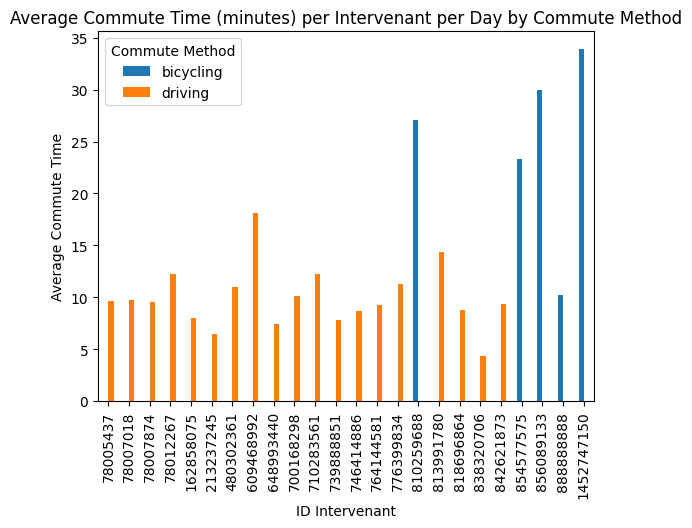

In [26]:
df_agendas = pd.concat(all_intervenant_agendas)


# Average commute time per day per intervenant broken down by commute method
daily_commute_time = df_agendas.groupby(["ID Intervenant", "Date", "Commute Method"])["Commute Time"].mean().groupby(["ID Intervenant", "Commute Method"]).mean().unstack().plot(kind='bar')
plt.xlabel("ID Intervenant")
plt.ylabel("Average Commute Time")
plt.title("Average Commute Time (minutes) per Intervenant per Day by Commute Method")
plt.show()

In [27]:

if 'Commute Method' in df_agendas.columns:
    commute_time_by_method = df_agendas.groupby('Commute Method')['Commute Time'].mean().reset_index()
    
    fig = px.bar(commute_time_by_method, x='Commute Method', y='Commute Time', 
                 labels={'Commute Method': 'Commute Method', 'Commute Time': 'Average Commute Time (minutes)'},
                 title='Average Commute Time by Commute Method')
    fig.show()
else:
    print("The 'Commute Method' column is not available in the dataframe.")

In [28]:
def plot_daily_commute_time(intervenant_id, df_agendas):
    intervenant_data = df_agendas[df_agendas['ID Intervenant'] == intervenant_id]
    fig = px.box(intervenant_data, x='Date', y='Commute Time', title=f'Daily Commute Time for Intervenant {intervenant_id}')
    fig.show()

plot_daily_commute_time(78005437, df_agendas)

In [29]:
# Commute time per day per intervenat 
daily_commute_sum = df_agendas.groupby(['ID Intervenant', 'Date'], as_index=False)['Commute Time'].sum()

daily_commute_sum = daily_commute_sum.merge(intervenants_df[['ID Intervenant', 'Commute Method']], on='ID Intervenant', how='left')

daily_commute_sum['ID Intervenant'] = daily_commute_sum['ID Intervenant'].astype(str)  

fig = px.box(daily_commute_sum, x='ID Intervenant', y='Commute Time', color='Commute Method', title='Total Commute Time per Day per Intervenant', color_discrete_map={'driving': 'orange', 'bicycling': 'blue'})
fig.show()

# Client Personas (Question 3)

In [30]:
# Reload Data  
file_path = "../data/ChallengeXHEC23022024.xlsx"


excel_data = pd.ExcelFile(file_path)


jan24_df = pd.read_excel(excel_data, sheet_name="JAN24")
clients_df = pd.read_excel(excel_data, sheet_name="clients")
intervenants_df = pd.read_excel(excel_data, sheet_name="intervenants")

In [31]:
# Analyzing client data to create personas
paris_center_coords = {'Latitude': 48.864716, 'Longitude': 2.349014}

# Calculating the distance of each client from the Paris city center
clients_df['Distance from Paris Center'] = ((clients_df['Latitude'] - paris_center_coords['Latitude'])**2 + (clients_df['Longitude'] - paris_center_coords['Longitude'])**2)**0.5
client_service_summary = jan24_df.groupby('ID Client')['Prestation'].value_counts().unstack(fill_value=0)
combined_client_data = clients_df.join(client_service_summary, on='ID Client')
combined_client_data['Distance from Paris Center'] = clients_df['Distance from Paris Center']


In [32]:
combined_client_data

,ID Client,Latitude,Longitude,Distance from Paris Center,ACCOMPAGNEMENTS COURSES PA,ADMINISTRATION,AIDE MENAGERE,COORDINATION,FEMME DE MENAGE,FORMATION,GARDE D'ENFANTS,HOMMES TOUTES MAINS,REPAS,TOILETTE,VIE SOCIALE,VISITE MEDICALE
0,559475456,48.721052,1.375689,0.983870,0,0,0,0,0,0,0,0,61,31,0,0
1,559277088,48.721052,1.375689,0.983870,0,0,4,0,0,0,0,0,62,31,0,0
2,87852633,48.691944,1.498773,0.867617,0,0,0,0,4,1,0,0,0,62,59,0
3,243033408,48.726393,1.332848,1.025537,0,0,0,0,0,0,0,0,11,21,0,0
4,814940942,48.733174,1.370689,0.987128,0,0,0,0,0,0,0,0,14,29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,334442311,48.771381,1.292168,1.060959,0,0,1,0,0,0,0,0,0,0,0,0
114,621952854,48.742805,1.351704,1.004734,0,0,0,0,0,0,0,1,0,0,0,0
115,1452858131,48.776801,1.370417,0.982538,0,0,0,0,0,0,0,0,0,3,0,0
116,846949801,48.733484,1.371047,0.986733,0,0,0,1,0,0,0,0,0,0,0,0


In [33]:
# Persona A: Central City Dweller Needing Regular Meals
persona_a_clients = combined_client_data[(combined_client_data['Distance from Paris Center'] <= combined_client_data['Distance from Paris Center'].quantile(0.25)) & (combined_client_data['REPAS'] > 0)].head()


persona_a_clients

,ID Client,Latitude,Longitude,Distance from Paris Center,ACCOMPAGNEMENTS COURSES PA,ADMINISTRATION,AIDE MENAGERE,COORDINATION,FEMME DE MENAGE,FORMATION,GARDE D'ENFANTS,HOMMES TOUTES MAINS,REPAS,TOILETTE,VIE SOCIALE,VISITE MEDICALE
19,446362468,48.725138,1.436412,0.923214,9,0,6,0,0,0,0,0,58,31,5,0
24,658302934,48.739911,1.382565,0.974474,2,0,4,1,0,1,0,0,31,31,0,0
29,466678534,48.747188,1.421348,0.935081,4,0,5,0,0,0,0,0,37,23,0,0
39,560575760,48.850785,1.434905,0.914215,0,0,7,1,0,0,0,1,27,7,0,0
42,458296232,48.748881,1.418857,0.937342,0,0,0,0,0,0,0,0,21,47,0,0


In [34]:
# Persona B: Suburban Senior with Mobility Assistance Needs
persona_b_clients = combined_client_data[(combined_client_data['Distance from Paris Center'] > combined_client_data['Distance from Paris Center'].quantile(0.25)) & (combined_client_data['Distance from Paris Center'] <= combined_client_data['Distance from Paris Center'].quantile(0.75)) & (combined_client_data['TOILETTE'] > 0)].head()

persona_b_clients

,ID Client,Latitude,Longitude,Distance from Paris Center,ACCOMPAGNEMENTS COURSES PA,ADMINISTRATION,AIDE MENAGERE,COORDINATION,FEMME DE MENAGE,FORMATION,GARDE D'ENFANTS,HOMMES TOUTES MAINS,REPAS,TOILETTE,VIE SOCIALE,VISITE MEDICALE
0,559475456,48.721052,1.375689,0.983870,0,0,0,0,0,0,0,0,61,31,0,0
1,559277088,48.721052,1.375689,0.983870,0,0,4,0,0,0,0,0,62,31,0,0
4,814940942,48.733174,1.370689,0.987128,0,0,0,0,0,0,0,0,14,29,0,0
7,480337694,48.729735,1.339050,1.018944,0,0,0,0,0,0,0,0,25,13,0,0
10,315244686,48.732218,1.363744,0.994140,0,0,5,0,0,0,0,0,22,62,0,0


In [35]:
#Persona C: Remote Client Needing Weekly Check-ins
persona_c_clients = combined_client_data[(combined_client_data['Distance from Paris Center'] > combined_client_data['Distance from Paris Center'].quantile(0.75)) & (combined_client_data['REPAS'] <= 2)].head()

persona_c_clients


,ID Client,Latitude,Longitude,Distance from Paris Center,ACCOMPAGNEMENTS COURSES PA,ADMINISTRATION,AIDE MENAGERE,COORDINATION,FEMME DE MENAGE,FORMATION,GARDE D'ENFANTS,HOMMES TOUTES MAINS,REPAS,TOILETTE,VIE SOCIALE,VISITE MEDICALE
5,864411156,48.766414,1.190890,1.162288,0,0,0,1,0,0,0,0,0,62,0,0
8,861502972,48.766414,1.190890,1.162288,0,0,0,0,0,0,0,0,0,17,0,0
20,859852985,48.762767,1.202870,1.150670,0,0,0,0,0,0,0,0,0,31,0,0
23,867813356,48.669269,1.279635,1.087093,0,0,0,0,0,3,0,0,0,62,0,0
27,762149315,48.768625,1.186807,1.166173,0,0,0,0,0,0,0,0,0,9,0,0


In [36]:

jan24_df['Start Hour'] = jan24_df['Heure de début'].apply(lambda x: x.hour)
jan24_df['End Hour'] = jan24_df['Heure de fin'].apply(lambda x: x.hour)

# Persona E:  Adults Needing Evening Assistance (services post 5 PM)
persona_e_clients = jan24_df[jan24_df['Start Hour'] >= 17]['ID Client'].value_counts().head().index.tolist()

In [37]:
jan24_df['Day of Week'] = jan24_df['Date'].dt.dayofweek
# Persona F: Weekend Assistance Client (services on weekends)
persona_f_clients = jan24_df[jan24_df['Day of Week'] >= 5]['ID Client'].value_counts().head().index.tolist()



In [38]:
# Persona H: Clients Needing Frequent Short Visits (Services less than or equal to 1 hour)
jan24_df['Service Duration'] = jan24_df['End Hour'] - jan24_df['Start Hour']
short_duration_clients = jan24_df[jan24_df['Service Duration'] <= 1]
persona_h_clients = short_duration_clients['ID Client'].value_counts().head().index.tolist()

In [39]:
# Persona I: Early Morning Service Client (services before 8 AM)
early_morning_clients = jan24_df[jan24_df['Start Hour'] < 8]
persona_i_clients = early_morning_clients['ID Client'].value_counts().head().index.tolist()


In [40]:
# Persona J: High Frequency Care Recipient (multiple services throughout the day)
high_frequency_clients = jan24_df['ID Client'].value_counts()
persona_j_clients = high_frequency_clients[high_frequency_clients > high_frequency_clients.quantile(0.75)].index.tolist()[:5]

In [41]:
# Persona K: Infrequent, but Long Duration Visits (longer duration, fewer appointments)
long_duration_clients = jan24_df[jan24_df['Service Duration'] > jan24_df['Service Duration'].quantile(0.75)]
infrequent_long_duration_clients = long_duration_clients['ID Client'].value_counts()
persona_k_clients = infrequent_long_duration_clients[infrequent_long_duration_clients < infrequent_long_duration_clients.quantile(0.25)].index.tolist()[:5]


In [42]:
# Persona L: Clients with Varied Service Needs (diverse types of services)
varied_service_clients = client_service_summary[client_service_summary > 0].count(axis=1)
persona_l_clients = varied_service_clients[varied_service_clients > varied_service_clients.quantile(0.75)].index.tolist()[:5]


# K-Means 

In [43]:
# Load data
file_path = "../data/ChallengeXHEC23022024.xlsx"
excel_data = pd.ExcelFile(file_path)


jan24_df = pd.read_excel(excel_data, sheet_name="JAN24")
clients_df = pd.read_excel(excel_data, sheet_name="clients")
intervenants_df = pd.read_excel(excel_data, sheet_name="intervenants")


paris_center_coords = {'Latitude': 48.864716, 'Longitude': 2.349014}


clients_df['Distance from Paris Center'] = np.sqrt((clients_df['Latitude'] - paris_center_coords['Latitude'])**2 + 
                                                   (clients_df['Longitude'] - paris_center_coords['Longitude'])**2)

# Convert service times to datetime 
fixed_date = pd.Timestamp('2024-01-01')
jan24_df['Heure de début'] = pd.to_datetime(fixed_date.strftime('%Y-%m-%d') + ' ' + jan24_df['Heure de début'].astype(str))
jan24_df['Heure de fin'] = pd.to_datetime(fixed_date.strftime('%Y-%m-%d') + ' ' + jan24_df['Heure de fin'].astype(str))


jan24_df['Service Duration'] = (jan24_df['Heure de fin'] - jan24_df['Heure de début']).dt.total_seconds() / 60 # In Minutes


In [44]:
client_service_count = jan24_df.groupby('ID Client')['Prestation'].count()
client_service_duration = jan24_df.groupby('ID Client')['Service Duration'].sum()

combined_client_data = clients_df.set_index('ID Client').join([client_service_count, client_service_duration], how='left')
combined_client_data.rename(columns={'Prestation': 'Total Services', 'Service Duration': 'Total Service Duration'}, inplace=True)

In [45]:
combined_client_data['Average Service Duration'] = combined_client_data['Total Service Duration'] / combined_client_data['Total Services']
service_variety = jan24_df.groupby('ID Client')['Prestation'].nunique()

combined_client_data = combined_client_data.join(service_variety, how='left')
combined_client_data.rename(columns={'Prestation': 'Service Variety'}, inplace=True)

total_days_in_january = jan24_df['Date'].nunique()
combined_client_data['Service Frequency'] = combined_client_data['Total Services'] / total_days_in_january

In [46]:
features_for_clustering = combined_client_data[['Distance from Paris Center', 'Total Services', 'Total Service Duration', 'Average Service Duration', 'Service Variety', 'Service Frequency']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)


kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(features_scaled)


combined_client_data['Cluster'] = kmeans.labels_

combined_client_data.head()

,Latitude,Longitude,Distance from Paris Center,Total Services,Total Service Duration,Average Service Duration,Service Variety,Service Frequency,Cluster
ID Client,,,,,,,,,
559475456,48.721052,1.375689,0.983870,92,3690.0,40.108696,2,2.967742,3
559277088,48.721052,1.375689,0.983870,97,2355.0,24.278351,3,3.129032,3
87852633,48.691944,1.498773,0.867617,126,3480.0,27.619048,4,4.064516,3
243033408,48.726393,1.332848,1.025537,32,1075.0,33.593750,2,1.032258,2
814940942,48.733174,1.370689,0.987128,43,2545.0,59.186047,2,1.387097,2


In [47]:
cluster_counts = combined_client_data['Cluster'].value_counts().sort_index()
print(cluster_counts)

Cluster
0     9
1    59
2    33
3    17
Name: count, dtype: int64


In [48]:
for i in range(kmeans.n_clusters):
    cluster_data = combined_client_data[combined_client_data['Cluster'] == i]
    print(f"Cluster {i} Statistics:")
    print(cluster_data.describe())
    print("\n")

Cluster 0 Statistics:
        Latitude  Longitude  Distance from Paris Center  Total Services  \
count   9.000000   9.000000                    9.000000        9.000000   
mean   48.731812   1.219892                    1.138555       10.333333   
std     0.063091   0.030648                    0.026968        9.069179   
min    48.586883   1.186807                    1.091073        2.000000   
25%    48.757396   1.199216                    1.118423        5.000000   
50%    48.758928   1.202870                    1.150670        7.000000   
75%    48.762767   1.235595                    1.154728       13.000000   
max    48.768625   1.276241                    1.166173       31.000000   

       Total Service Duration  Average Service Duration  Service Variety  \
count                9.000000                  9.000000              9.0   
mean               443.333333                 57.970430              1.0   
std                230.081507                 28.691663              0.0  

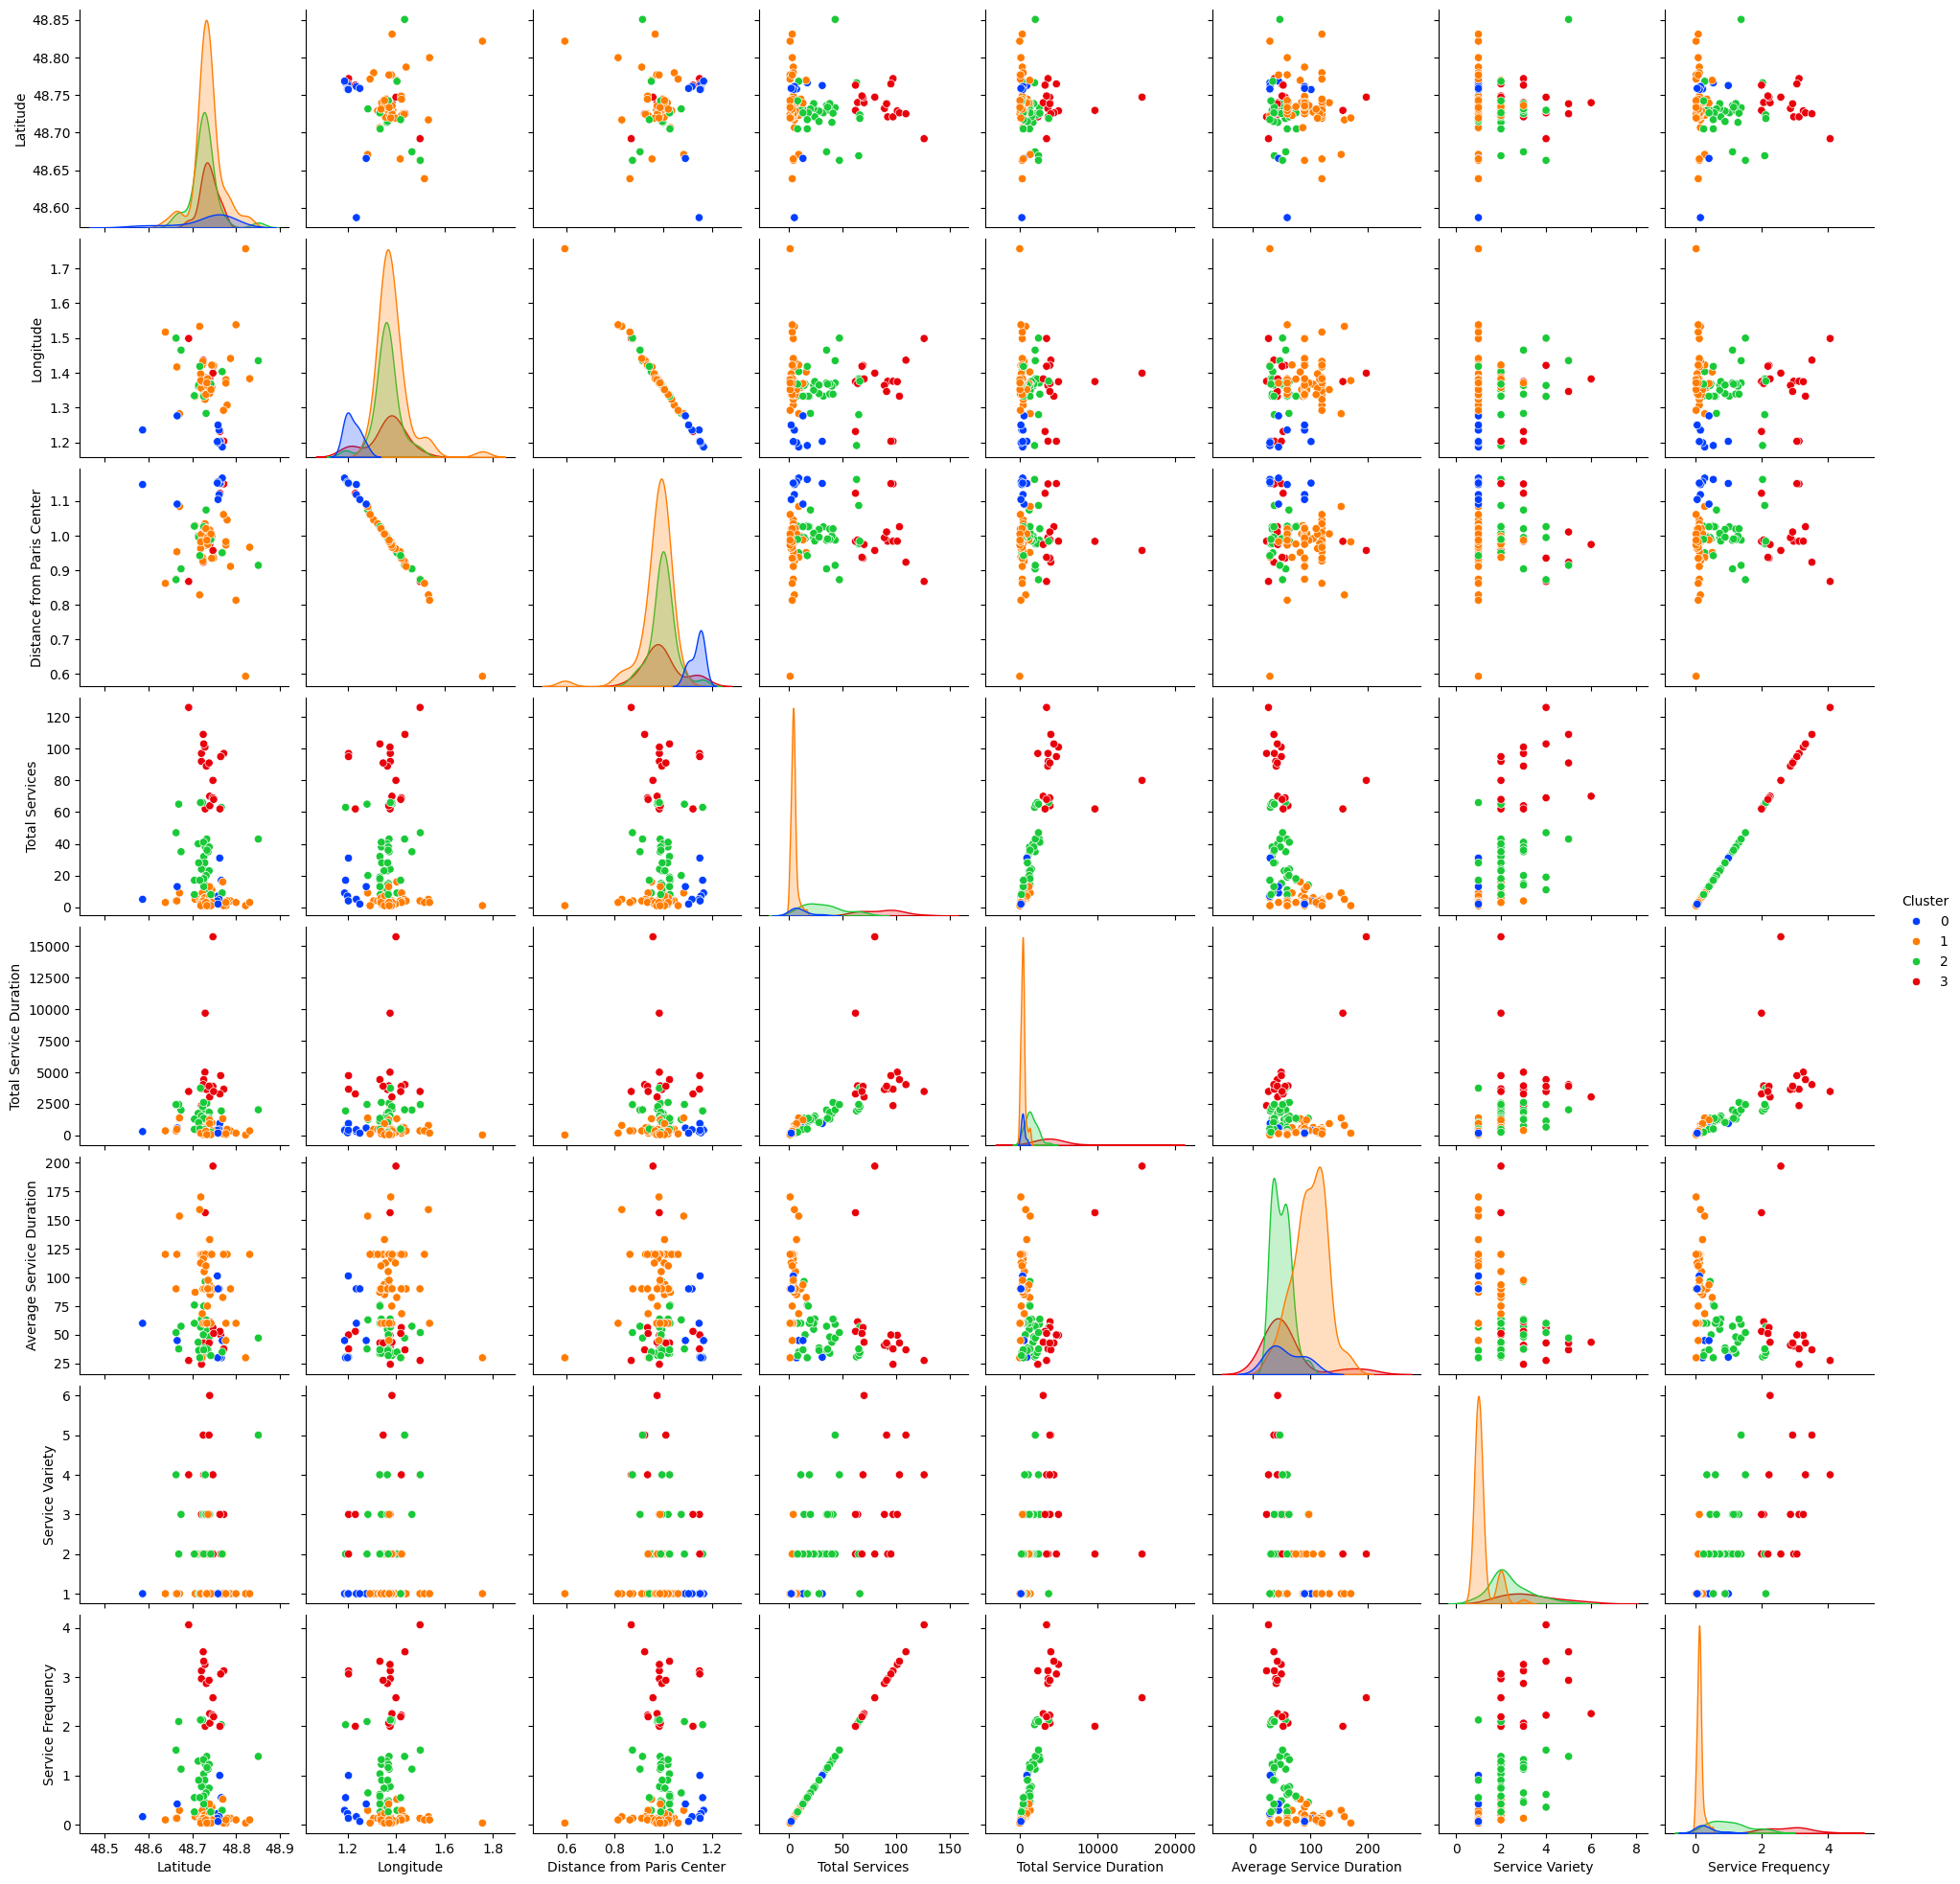

In [49]:
sns.pairplot(combined_client_data, hue='Cluster', palette='bright')
plt.show()